

```
# Created by: Dhruv Bejugam
# Last Updated on: 07/11/22
# Summary: PDE approximator created using neurodiffeq library and documentation

```



In [ ]:
pip install -U neurodiffeq

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
from neurodiffeq.networks import FCNN 
from neurodiffeq import diff
import torch
import torchvision

/usr/local/lib/python3.7/dist-packages/neurodiffeq/monitors.py:48: UserWarning: You seem to be using jupyter notebook with '%matplotlib inline' which can lead to monitor plots not updating. Consider using '%matplotlib notebook' or '%matplotlib widget' instead.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/neurodiffeq/monitors.py:652: UserWarning: Heatmap-style solution does not work with your matplotlib version. Please upgrade matplotlib to v3.3.0 or higher. Otherwise you may experience buggy behavior.
  UserWarning)


Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

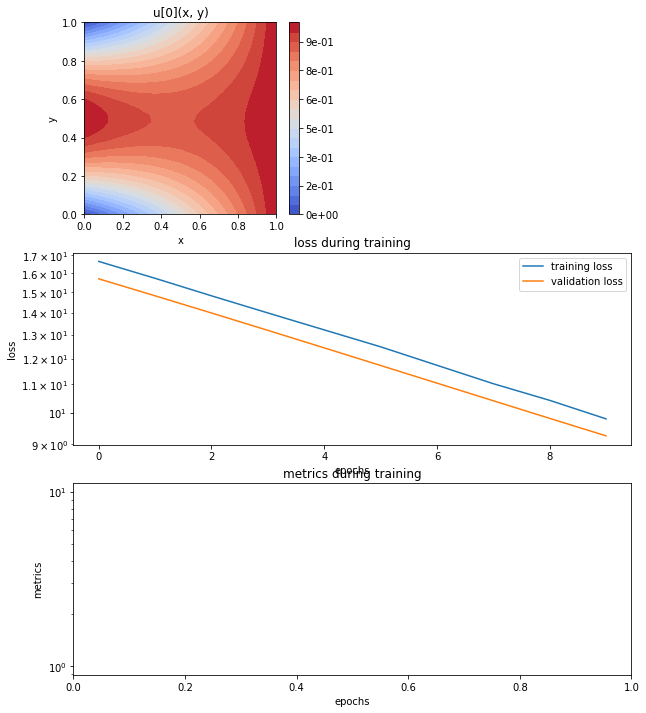

In [10]:
# Define the PDE system as one Laplace equation
laplace = lambda u, x, y: [
    diff(u, x, order=2) + diff(u, y, order=2)
]

# Define the boundary conditions
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: torch.sin(np.pi*y),
        x_max=1, x_max_val=lambda y: 1,
        y_min=0, y_min_val=lambda x: 2,
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define neural network 
nets = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=[512])
]

# Define monitor callback
monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate solver
solver = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  
    xy_max=(1, 1), 
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=200, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_laplace = solver.get_solution()

In [11]:
from mpl_toolkits.mplot3d  import Axes3D
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = plt.subplot(111, projection="3d")
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    fig.suptitle(title)
    ax.set_proj_type('ortho')
    plt.show()

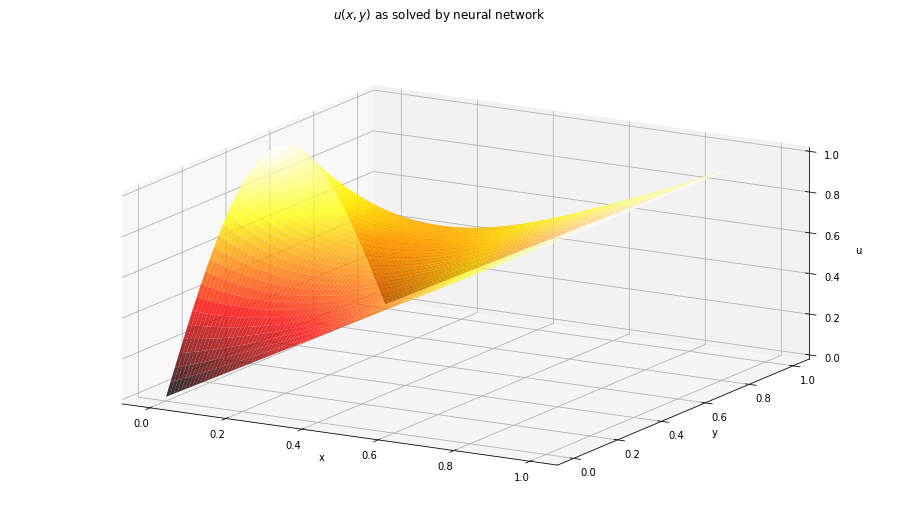

In [12]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
sol_net = solution_neural_net_laplace(xx, yy, to_numpy=True)
plt_surf(xx, yy, sol_net, title='$u(x, y)$ as solved by neural network')

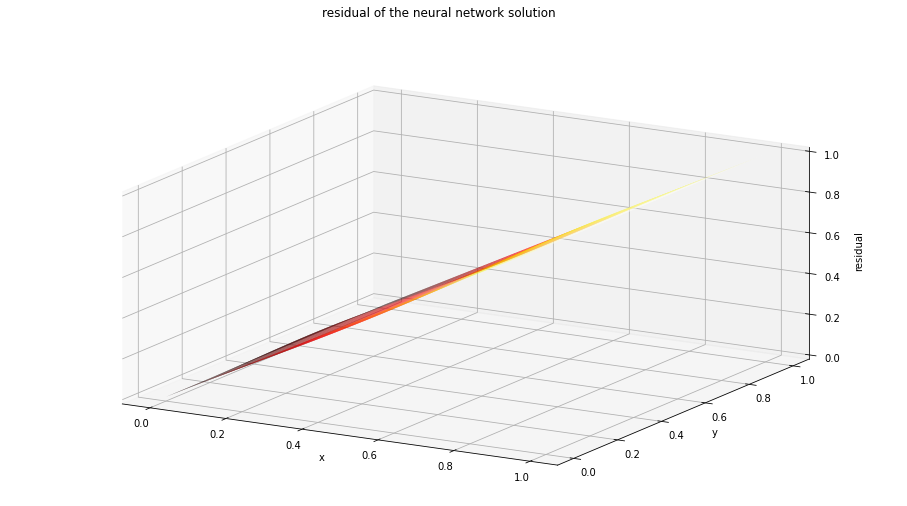

In [13]:
solution_analytical_laplace = lambda x, y: np.sin(np.pi*y) * np.sinh(np.pi*(1-x))/np.sinh(np.pi)
sol_ana = solution_analytical_laplace(xx, yy)
plt_surf(xx, yy, sol_net-sol_ana, z_label='residual', title='residual of the neural network solution')